## Getting the dataset

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'xxx'
os.environ['KAGGLE_KEY'] = 'xxxxxxxxxxxxxx'

In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Checking out the data/images

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

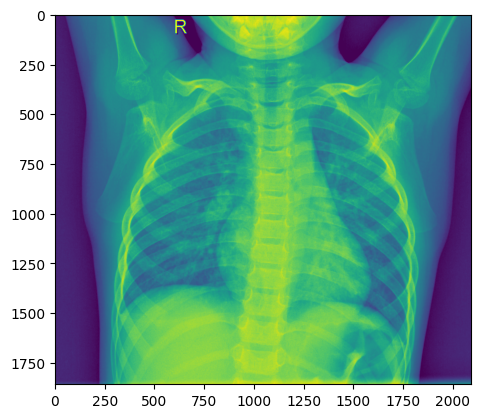

In [6]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [8]:
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1

In [9]:
plot_images(training_dir + '/NORMAL')

In [10]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

## Train the model

In [11]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

In [12]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [13]:
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(2, activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  model.summary()
  return model

In [14]:
model = get_model()

87910968/87910968 [==============================] - 34s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                 

In [15]:
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

C:\Users\pc\AppData\Local\Temp\ipykernel_4100\883596967.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
163/163 [==============================] - 321s 2s/step - loss: 0.3619 - accuracy: 0.8869 - val_loss: 0.4391 - val_accuracy: 0.8718
Epoch 2/5
163/163 [==============================] - 228s 1s/step - loss: 0.2103 - accuracy: 0.9225 - val_loss: 0.3720 - val_accuracy: 0.8686
Epoch 3/5
163/163 [==============================] - 231s 1s/step - loss: 0.1949 - accuracy: 0.9233 - val_loss: 0.3731 - val_accuracy: 0.8686
Epoch 4/5
163/163 [==============================] - 225s 1s/step - loss: 0.1817 - accuracy: 0.9283 - val_loss: 0.4626 - val_accuracy: 0.8317
Epoch 5/5
163/163 [==============================] - 226s 1s/step - loss: 0.1941 - accuracy: 0.9235 - val_loss: 0.4289 - val_accuracy: 0.8365


## Evaluate the model

In [16]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

C:\Users\pc\AppData\Local\Temp\ipykernel_4100\2398612203.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)


16/16 [==============================] - 1s 67ms/step - loss: 1.2215 - accuracy: 0.5625
Loss: 1.221524715423584
Accuracy: 0.5625


In [17]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches

1/1 [==============================] - 0s 96ms/step


[array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64)]

In [19]:
def predict_images(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 8:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img)

      amount += 1

In [20]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

In [21]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')

## Model saving and loading

In [22]:
model.save('awesome_model.h5')

In [23]:
new_model = keras.models.load_model('awesome_model.h5')